# Load Packages

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


# Load Data

In [111]:
# train_df = pd.read_csv("../Data/processed/training_full_with_extra_features.csv", sep="\t")
# val_df = pd.read_csv("../Data/processed/validation_full_with_extra_features.csv", sep="\t")
train_df = pd.read_csv("../Data/processed/training_full.csv", sep="\t")
val_df = pd.read_csv("../Data/processed/validation_full.csv", sep="\t")

# Check Columns

In [112]:
val_df = val_df[train_df.drop(columns="ActualTOW").columns]

In [113]:
X_train = train_df.drop(columns=["ActualTOW"])
y_train = train_df["ActualTOW"]
X_val = val_df.copy()

# Prepare Transform

In [114]:

num_features = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])



# Voting Regressor

In [115]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2, random_state=42)



voting_model = VotingRegressor(
    estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
    weights=[1, 1, 1],
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", voting_model)
])


# Training

In [116]:

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ActualFlightTime',
                                                   'ActualTotalFuel',
                                                   'FlownPassengers',
                                                   'BagsCount',
                                                   'FlightBagsWeight']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='i...
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.2,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=6,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=200,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))],
                                 n_jobs=-1, weights=[1, 1, 1]))])

# Evaluate

In [117]:
y_train_pred = pipeline.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.2f}")
print(f"Training MAE: {mae:.2f}")


Training RMSE: 668.61
Training MAE: 494.20


# Plot True vs Predicted

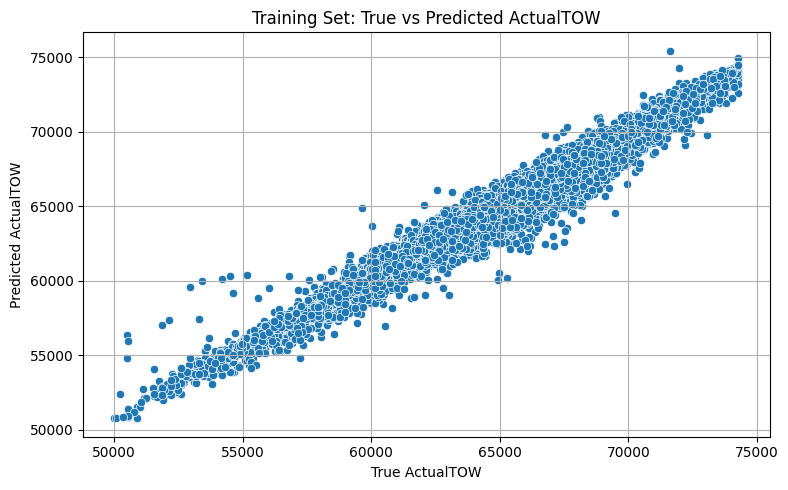

In [118]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel("True ActualTOW")
plt.ylabel("Predicted ActualTOW")
plt.title("Training Set: True vs Predicted ActualTOW")
plt.grid(True)
plt.tight_layout()
plt.show()

# Prediction

In [119]:
y_val_pred = pipeline.predict(X_val)

# Save Results

In [120]:

preds = pd.DataFrame({"ActualTOW": y_val_pred})
val_original = pd.read_csv("../Data/validation.csv", sep="\t")
val_original = val_original.copy()
val_original["ActualTOW"] = preds["ActualTOW"]
val_original.to_csv("../Data/solution/validation_predictions.csv", sep="\t", index=False)
preds.to_csv("../Data/solution/validation_predictions_only_ActualTOW.csv", sep="\t", index=False)
val_df["ActualTOW"] = preds["ActualTOW"]
val_df.to_csv("../Data/solution/validation_full_with_predictions.csv", sep="\t", index=False)